In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

In [2]:
prices = pd.read_excel('commod_data.xlsx', index_col=0)
print (prices)

            CRUDOIL  GOLDBLN  LCPCASH  EIAEBRT  OILBREN  WHEATSF  LAHCASH  \
Date                                                                        
2008-08-01   123.26   914.40   8073.0   124.16   123.98     5.83  2884.45   
2008-08-04   121.41   906.20   7734.0   121.87   121.63     5.53  2831.00   
2008-08-05   119.17   880.40   7768.0   116.50   116.88     5.92  2849.50   
2008-08-06   118.58   878.40   7767.0   114.47   114.62     5.83  2855.75   
2008-08-07   120.02   872.85   7810.0   116.94   117.00     6.21  2868.25   
...             ...      ...      ...      ...      ...      ...      ...   
2022-04-25    99.49  1898.40   9783.8    99.27   102.22    10.71  3073.50   
2022-04-26   101.70  1905.32   9863.5   102.89   105.08    10.92  3048.60   
2022-04-27   102.02  1885.36   9866.5   103.30   105.33    10.90  3080.70   
2022-04-28   105.36  1887.25   9696.0   105.78   107.83    10.85  3015.50   
2022-04-29   104.69  1908.49   9770.5   108.36   107.83    10.58  3032.50   

In [3]:
returns = prices.pct_change().dropna()
print(returns)


             CRUDOIL   GOLDBLN   LCPCASH   EIAEBRT   OILBREN   WHEATSF  \
Date                                                                     
2008-08-04 -0.015009 -0.008968 -0.041992 -0.018444 -0.018955 -0.051458   
2008-08-05 -0.018450 -0.028471  0.004396 -0.044063 -0.039053  0.070524   
2008-08-06 -0.004951 -0.002272 -0.000129 -0.017425 -0.019336 -0.015203   
2008-08-07  0.012144 -0.006318  0.005536  0.021578  0.020764  0.065180   
2008-08-08 -0.040160 -0.023429 -0.036748 -0.033436 -0.027949 -0.067633   
...              ...       ...       ...       ...       ...       ...   
2022-04-25 -0.033233 -0.015582 -0.032576 -0.055920 -0.041358 -0.001864   
2022-04-26  0.022213  0.003645  0.008146  0.036466  0.027979  0.019608   
2022-04-27  0.003147 -0.010476  0.000304  0.003985  0.002379 -0.001832   
2022-04-28  0.032739  0.001002 -0.017281  0.024008  0.023735 -0.004587   
2022-04-29 -0.006359  0.011254  0.007684  0.024390  0.000000 -0.024885   

             LAHCASH   LNICASH   CORN

In [4]:
def pair_trading(leg1_price,leg1_return,leg2_price,leg2_returns,window):
    
    
    #Rolling OLS hedge ratio
    endog = leg1_price
    exog = leg2_price
    rols = RollingOLS(endog, exog, window)
    rres = rols.fit()
    params = rres.params.copy()
    params.head()    
    params.tail()
    params.columns = ['Hedge ratio']
    hedge_ratio = params['Hedge ratio']
    #print (params)

    
    
    
    
    
    
    
    
    
    raw_data= leg1_price - (hedge_ratio*leg2_price)
    raw_data = pd.DataFrame(raw_data)
    raw_data.columns = ['Spread']
    raw_data = pd.concat([raw_data, leg1_price,leg2_price], axis=1)
    returns = prices.pct_change().dropna()
    
    
    raw_data['Spread_rolling_std'] = raw_data['Spread'].rolling(window).std()
    raw_data['Hedge ratio']= hedge_ratio
    raw_data['Position']=0
    raw_data.loc[raw_data['Spread'] > raw_data['Spread_rolling_std']*0, 'Position'] = -1
    raw_data.loc[raw_data['Spread'] < raw_data['Spread_rolling_std']*0, 'Position'] = 1
    raw_data.loc[raw_data['Spread'] > raw_data['Spread_rolling_std']*1, 'Position'] = -3
    raw_data.loc[raw_data['Spread'] < raw_data['Spread_rolling_std']*-1, 'Position'] = 3
    raw_data.loc[raw_data['Spread'] > raw_data['Spread_rolling_std']*2, 'Position'] = -5
    raw_data.loc[raw_data['Spread'] < raw_data['Spread_rolling_std']*-2, 'Position'] = 5
    raw_data.loc[raw_data['Spread'] > raw_data['Spread_rolling_std']*2.5, 'Position'] = 0
    raw_data.loc[raw_data['Spread'] < raw_data['Spread_rolling_std']*-2.5, 'Position'] = 0
    
    raw_data['Position'] = raw_data['Position'] .shift(1)
    
    raw_data['Leg1_position'] = raw_data['Position']
    raw_data['Leg2_position'] = raw_data['Position']*hedge_ratio*-1
    raw_data['dailypnl'] = raw_data['Leg1_position']*leg1_return.shift(-1) + raw_data['Leg2_position'] *leg2_returns.shift(-1)
    data_2018= raw_data.loc['2018-01-01':,].copy()

    data_2018['cumpnl'] = data_2018['dailypnl'].cumsum()
    print (data_2018)
    return (data_2018)





In [5]:
rollingwindow = 252
EIAEBRT_OILBREN_PnL=pair_trading(leg1_price=prices['EIAEBRT'],leg1_return=returns['EIAEBRT'],leg2_price=prices['OILBREN'],leg2_returns=returns['OILBREN'],window=rollingwindow)
EIAEBRT_BFO1MEU_PnL=pair_trading(leg1_price=prices['EIAEBRT'],leg1_return=returns['EIAEBRT'],leg2_price=prices['BFO1MEU'],leg2_returns=returns['BFO1MEU'],window=rollingwindow)
EIAEBRT_GOEUARA_PnL=pair_trading(leg1_price=prices['EIAEBRT'],leg1_return=returns['EIAEBRT'],leg2_price=prices['GOEUARA'],leg2_returns=returns['GOEUARA'],window=rollingwindow)
EIAEBRT_DIESELA_PnL=pair_trading(leg1_price=prices['EIAEBRT'],leg1_return=returns['EIAEBRT'],leg2_price=prices['DIESELA'],leg2_returns=returns['DIESELA'],window=rollingwindow)
CRUDOIL_NAFCNWE_PnL=pair_trading(leg1_price=prices['CRUDOIL'],leg1_return=returns['CRUDOIL'],leg2_price=prices['NAFCNWE'],leg2_returns=returns['NAFCNWE'],window=rollingwindow)
CRUDOIL_ETHANYH_PnL=pair_trading(leg1_price=prices['CRUDOIL'],leg1_return=returns['CRUDOIL'],leg2_price=prices['EIAUSGJ'],leg2_returns=returns['EIAUSGJ'],window=rollingwindow)
LCPCASH_JETCNWE_PnL=pair_trading(leg1_price=prices['LCPCASH'],leg1_return=returns['LCPCASH'],leg2_price=prices['JETCNWE'],leg2_returns=returns['JETCNWE'],window=rollingwindow)
LCPCASH_LTICASH_PnL=pair_trading(leg1_price=prices['LCPCASH'],leg1_return=returns['LCPCASH'],leg2_price=prices['LTICASH'],leg2_returns=returns['LTICASH'],window=rollingwindow)
PALLADM_LZZCASH_PnL=pair_trading(leg1_price=prices['PALLADM'],leg1_return=returns['PALLADM'],leg2_price=prices['LZZCASH'],leg2_returns=returns['LZZCASH'],window=rollingwindow)
LNICASH_RHODNWE_PnL=pair_trading(leg1_price=prices['LNICASH'],leg1_return=returns['LNICASH'],leg2_price=prices['RHODNWE'],leg2_returns=returns['RHODNWE'],window=rollingwindow)
LCPCASH_GOEUARA_PnL=pair_trading(leg1_price=prices['LCPCASH'],leg1_return=returns['LCPCASH'],leg2_price=prices['GOEUARA'],leg2_returns=returns['GOEUARA'],window=rollingwindow)
WHEATSF_NAFCNWE_PnL=pair_trading(leg1_price=prices['WHEATSF'],leg1_return=returns['WHEATSF'],leg2_price=prices['NAFCNWE'],leg2_returns=returns['NAFCNWE'],window=rollingwindow)
WHEATSF_EIANYGR_PnL=pair_trading(leg1_price=prices['WHEATSF'],leg1_return=returns['WHEATSF'],leg2_price=prices['EIANYGR'],leg2_returns=returns['EIANYGR'],window=rollingwindow)
WHEATSF_EIAGCGR_PnL=pair_trading(leg1_price=prices['WHEATSF'],leg1_return=returns['WHEATSF'],leg2_price=prices['EIAGCGR'],leg2_returns=returns['EIAGCGR'],window=rollingwindow)
WHEATSF_NATBGAS_PnL=pair_trading(leg1_price=prices['WHEATSF'],leg1_return=returns['WHEATSF'],leg2_price=prices['NATBGAS'],leg2_returns=returns['NATBGAS'],window=rollingwindow)



            Hedge ratio
Date                   
2008-08-01          NaN
2008-08-04          NaN
2008-08-05          NaN
2008-08-06          NaN
2008-08-07          NaN
...                 ...
2022-04-25     1.009809
2022-04-26     1.009632
2022-04-27     1.009471
2022-04-28     1.009306
2022-04-29     1.009290

[3586 rows x 1 columns]
              Spread  EIAEBRT  OILBREN  Spread_rolling_std  Hedge ratio  \
Date                                                                      
2018-01-01  0.790486    66.73    66.61            0.662692     0.989934   
2018-01-02  0.960420    66.65    66.35            0.662864     0.990046   
2018-01-03  1.012538    67.85    67.50            0.663117     0.990185   
2018-01-04  1.336096    68.73    68.05            0.664227     0.990359   
2018-01-05  1.070511    68.01    67.58            0.664086     0.990522   
...              ...      ...      ...                 ...          ...   
2022-04-25 -3.952636    99.27   102.22            1.657380     

            Hedge ratio
Date                   
2008-08-01          NaN
2008-08-04          NaN
2008-08-05          NaN
2008-08-06          NaN
2008-08-07          NaN
...                 ...
2022-04-25     0.107170
2022-04-26     0.107221
2022-04-27     0.107256
2022-04-28     0.107305
2022-04-29     0.107334

[3586 rows x 1 columns]
              Spread  CRUDOIL  NAFCNWE  Spread_rolling_std  Hedge ratio  \
Date                                                                      
2018-01-01 -1.586075    60.42    593.8            2.165986     0.104422   
2018-01-02 -1.494942    60.37    592.5            2.159675     0.104413   
2018-01-03 -0.490709    61.63    595.0            2.160340     0.104405   
2018-01-04  0.409530    62.01    590.0            2.163276     0.104408   
2018-01-05  0.041806    61.44    588.0            2.157850     0.104419   
...              ...      ...      ...                 ...          ...   
2022-04-25  8.716835    99.49    847.0            2.960473     

            Hedge ratio
Date                   
2008-08-01          NaN
2008-08-04          NaN
2008-08-05          NaN
2008-08-06          NaN
2008-08-07          NaN
...                 ...
2022-04-25     0.678358
2022-04-26     0.676507
2022-04-27     0.674582
2022-04-28     0.672831
2022-04-29     0.671198

[3586 rows x 1 columns]
                Spread  PALLADM  LZZCASH  Spread_rolling_std  Hedge ratio  \
Date                                                                        
2018-01-01   49.707579   1056.0  3337.50           50.108739     0.301511   
2018-01-02   69.387440   1087.0  3372.50           49.838689     0.301738   
2018-01-03   75.494940   1086.0  3346.50           49.656937     0.301959   
2018-01-04   77.364178   1100.0  3384.50           49.604495     0.302153   
2018-01-05   72.941467   1095.0  3380.00           49.347464     0.302384   
...                ...      ...      ...                 ...          ...   
2022-04-25 -749.536702   2115.0  4222.75       

            Hedge ratio
Date                   
2008-08-01          NaN
2008-08-04          NaN
2008-08-05          NaN
2008-08-06          NaN
2008-08-07          NaN
...                 ...
2022-04-25     3.048752
2022-04-26     3.048449
2022-04-27     3.047988
2022-04-28     3.047141
2022-04-29     3.046196

[3586 rows x 1 columns]
              Spread  WHEATSF  EIANYGR  Spread_rolling_std  Hedge ratio  \
Date                                                                      
2018-01-01 -0.503615     4.32    1.829            0.554371     2.637296   
2018-01-02 -0.345111     4.38    1.792            0.553312     2.636781   
2018-01-03 -0.383059     4.42    1.822            0.552346     2.636147   
2018-01-04 -0.427551     4.40    1.832            0.551907     2.635126   
2018-01-05 -0.425751     4.36    1.817            0.551827     2.633875   
...              ...      ...      ...                 ...          ...   
2022-04-25  0.859484    10.71    3.231            1.080449     

In [6]:
EIAEBRT_OILBREN_PnL.to_csv("EIAEBRT_OILBREN_PnL.csv")
EIAEBRT_BFO1MEU_PnL.to_csv("EIAEBRT_BFO1MEU_PnL.csv")  
EIAEBRT_GOEUARA_PnL.to_csv("EIAEBRT_GOEUARA_PnL.csv")  
EIAEBRT_DIESELA_PnL.to_csv("EIAEBRT_DIESELA_PnL.csv")  
CRUDOIL_NAFCNWE_PnL.to_csv("CRUDOIL_NAFCNWE_PnL.csv")  
CRUDOIL_ETHANYH_PnL.to_csv("CRUDOIL_ETHANYH_PnL.csv")  
LCPCASH_JETCNWE_PnL.to_csv("LCPCASH_JETCNWE_PnL.csv")  
LCPCASH_LTICASH_PnL.to_csv("LCPCASH_LTICASH_PnL.csv")  
PALLADM_LZZCASH_PnL.to_csv("PALLADM_LZZCASH_PnL.csv")  
LNICASH_RHODNWE_PnL.to_csv("LNICASH_RHODNWE_PnL.csv")  
LCPCASH_GOEUARA_PnL.to_csv("LCPCASH_GOEUARA_PnL.csv")  
WHEATSF_NAFCNWE_PnL.to_csv("WHEATSF_NAFCNWE_PnL.csv")  
WHEATSF_EIANYGR_PnL.to_csv("WHEATSF_EIANYGR_PnL.csv")  
WHEATSF_EIAGCGR_PnL.to_csv("WHEATSF_EIAGCGR_PnL.csv")  
WHEATSF_NATBGAS_PnL.to_csv("WHEATSF_NATBGAS_PnL.csv")  
 

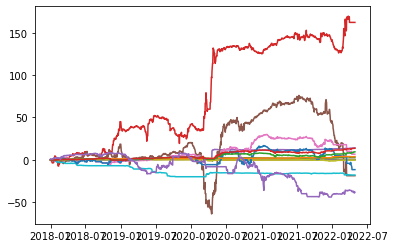

In [7]:
plt.plot(EIAEBRT_OILBREN_PnL['cumpnl'], label='EIAEBRT_OILBREN_PnL')
plt.plot(EIAEBRT_BFO1MEU_PnL['cumpnl'], label='EIAEBRT_BFO1MEU_PnL')
plt.plot(EIAEBRT_GOEUARA_PnL['cumpnl'], label='EIAEBRT_GOEUARA_PnL')
plt.plot(EIAEBRT_DIESELA_PnL['cumpnl'], label='EIAEBRT_DIESELA_PnL')
plt.plot(CRUDOIL_NAFCNWE_PnL['cumpnl'], label='CRUDOIL_NAFCNWE_PnL')
plt.plot(CRUDOIL_ETHANYH_PnL['cumpnl'], label='CRUDOIL_ETHANYH_PnL')
plt.plot(LCPCASH_JETCNWE_PnL['cumpnl'], label='LCPCASH_JETCNWE_PnL')
plt.plot(LCPCASH_LTICASH_PnL['cumpnl'], label='LCPCASH_LTICASH_PnL')
plt.plot(PALLADM_LZZCASH_PnL['cumpnl'], label='PALLADM_LZZCASH_PnL')
plt.plot(LNICASH_RHODNWE_PnL['cumpnl'], label='LNICASH_RHODNWE_PnL')
plt.plot(LCPCASH_GOEUARA_PnL['cumpnl'], label='LCPCASH_GOEUARA_PnL')
plt.plot(WHEATSF_NAFCNWE_PnL['cumpnl'], label='WHEATSF_NAFCNWE_PnL')
plt.plot(WHEATSF_EIANYGR_PnL['cumpnl'], label='WHEATSF_EIANYGR_PnL')
plt.plot(WHEATSF_EIAGCGR_PnL['cumpnl'], label='WHEATSF_EIAGCGR_PnL')
plt.plot(WHEATSF_NATBGAS_PnL['cumpnl'], label='WHEATSF_NATBGAS_PnL')

In [8]:
results = pd.DataFrame(index=['EIAEBRT_OILBREN_PnL','EIAEBRT_BFO1MEU_PnL','EIAEBRT_GOEUARA_PnL','EIAEBRT_DIESELA_PnL','CRUDOIL_NAFCNWE_PnL','CRUDOIL_ETHANYH_PnL','LCPCASH_JETCNWE_PnL','LCPCASH_LTICASH_PnL','PALLADM_LZZCASH_PnL','LNICASH_RHODNWE_PnL','LCPCASH_GOEUARA_PnL','WHEATSF_NAFCNWE_PnL','WHEATSF_EIANYGR_PnL','WHEATSF_EIAGCGR_PnL','WHEATSF_NATBGAS_PnL']
                       , columns=['Cumulative return'])
                                                                       
results.loc['EIAEBRT_OILBREN_PnL'] = EIAEBRT_OILBREN_PnL['cumpnl'][-2]
results.loc['EIAEBRT_BFO1MEU_PnL'] = EIAEBRT_BFO1MEU_PnL['cumpnl'][-2]
results.loc['EIAEBRT_GOEUARA_PnL'] = EIAEBRT_GOEUARA_PnL['cumpnl'][-2]
results.loc['EIAEBRT_DIESELA_PnL'] = EIAEBRT_DIESELA_PnL['cumpnl'][-2]
results.loc['CRUDOIL_NAFCNWE_PnL'] = CRUDOIL_NAFCNWE_PnL['cumpnl'][-2]
results.loc['CRUDOIL_ETHANYH_PnL'] = CRUDOIL_ETHANYH_PnL['cumpnl'][-2]
results.loc['LCPCASH_JETCNWE_PnL'] = LCPCASH_JETCNWE_PnL['cumpnl'][-2]
results.loc['LCPCASH_LTICASH_PnL'] = LCPCASH_LTICASH_PnL['cumpnl'][-2]
results.loc['PALLADM_LZZCASH_PnL'] = PALLADM_LZZCASH_PnL['cumpnl'][-2]
results.loc['LNICASH_RHODNWE_PnL'] = LNICASH_RHODNWE_PnL['cumpnl'][-2]
results.loc['LCPCASH_GOEUARA_PnL'] = LCPCASH_GOEUARA_PnL['cumpnl'][-2]
results.loc['WHEATSF_NAFCNWE_PnL'] = WHEATSF_NAFCNWE_PnL['cumpnl'][-2]
results.loc['WHEATSF_EIANYGR_PnL'] = WHEATSF_EIANYGR_PnL['cumpnl'][-2]
results.loc['WHEATSF_EIAGCGR_PnL'] = WHEATSF_EIAGCGR_PnL['cumpnl'][-2]
results.loc['WHEATSF_NATBGAS_PnL'] = WHEATSF_NATBGAS_PnL['cumpnl'][-2]

results.sort_values(by='Cumulative return', ascending=False)

,Cumulative return
EIAEBRT_DIESELA_PnL,162.224015
CRUDOIL_NAFCNWE_PnL,14.04351
WHEATSF_EIAGCGR_PnL,13.623589
WHEATSF_EIANYGR_PnL,9.484897
LCPCASH_JETCNWE_PnL,6.55488
WHEATSF_NAFCNWE_PnL,3.759696
EIAEBRT_GOEUARA_PnL,3.069401
EIAEBRT_OILBREN_PnL,0.51285
EIAEBRT_BFO1MEU_PnL,0.412062
LCPCASH_LTICASH_PnL,-0.053635
